In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os, fnmatch
import io
import seaborn as sns
%matplotlib inline

In [31]:
class DefSlamErrors(object):
    def __init__(self,base_dir, error_str):
        ''' The init function generates the pandas dataframes from the array of 
        string values contained in the base_dir directory, and it saves them in
        a python dictionary '''

        self.user_input = base_dir + '/Iter' + '0'
        directory = os.listdir(self.user_input)

        # Dictionary with dataframes of errors
        self.error_collection = {} 
        self.total_mean_error = {}
        self.total_std_error = {}

        for error_name in error_str:
            self.error_collection[error_name] = self.read_error(directory,error_name)
            self.total_mean_error[error_name] = np.nanmean(evaluation.error_collection[error_name].to_numpy())
            self.total_std_error[error_name]= np.nanstd(evaluation.error_collection['ErrorGTs'].to_numpy())

        # Dataframe with scale values. The df index corresponds with the image frame
        self.error_collection['Scale'] = pd.read_csv(self.find('Scale*', self.user_input)[0], 
                                                    index_col=0, header=None,
                                                    delim_whitespace=True, 
                                                    names=['Scale'])
        # Dataframe with the matches
        self.error_collection['Matches'] = pd.read_csv(self.find('Matches*', 
                                                                self.user_input)[0], 
                                                      index_col=0, header = None ,
                                                      names=['inliers',
                                                             'outliers',
                                                             'local map points'],
                                                      delim_whitespace=True)
        
        

    def find(self, pattern, path):
        result = []
        for root, dirs, files in os.walk(path):
            for name in files:
                if fnmatch.fnmatch(name, pattern):
                    result.append(os.path.join(root, name))
        return result

    def read_error(self,directory,filename):
        '''This class takes the directory where the error files are saved, as well
        as the first characters of the filename to be read (that is, the name
        template), and returns the pandas dataframe with the error values and the
        corresponding frame.  '''

        df_names = []
        df = []
        for file in directory:
            if file.startswith(filename):

                if df_names == []:
                    if not os.stat(self.user_input+"/"+file).st_size == 0:
                        df = pd.read_csv(self.user_input+"/"+file, header=None).transpose()
                        file = file.strip(filename) 
                        if filename == "ErrorGTs":
                          file = file.strip('.txt') 
                        else:
                          file = file.split("-")[0]
                        df_names.append(file)
                else:
                    if not os.stat(self.user_input+"/"+file).st_size == 0:
                        df_aux = pd.read_csv(self.user_input+"/"+file, header=None).transpose()
                        file = file.strip(filename) 
                        if filename == "ErrorGTs":
                          file = file.strip('.txt') 
                        else:
                          file = file.split("-")[0]
                        df_names.append(file)
                        df = pd.concat([df, df_aux])
            else:
                pass
            


        df['frame'] = df_names
        df['frame'] = df['frame'].astype('int32')

        df = df.sort_values(by='frame', ascending=True)

        return df


    def plot_error(self, error_str):
        ''' In a single function call, put the parameters you want to plot 
        TOGETHER in the same axis. The input is an array of strings with
        the names of the parameters to plot. Be careful that they match the names
        of the subsequent pandas dataframes'''

        #fig = plt.figure(figsize=(20, 6))
        fig, ax = plt.subplots(figsize=(20, 6))

        clrs = sns.color_palette("husl", len(error_str))
        sns.set_style('darkgrid')

        ax_all = []
        i = 0
        for error_name in error_str:
            ax = ax.twinx()
            if error_name == 'ErrorGTs':
                ax.plot(self.error_collection[error_name]['frame'],
                      (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1))*1000,
                      c = clrs[i])
                ax.fill_between(self.error_collection[error_name]['frame'], 
                              (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1)-self.error_collection[error_name].iloc[:,0:-1].std(axis=1))*1000, 
                              (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1)+self.error_collection[error_name].iloc[:,0:-1].std(axis=1))*1000 ,
                              alpha=0.3, facecolor=clrs[i])

                ax.set_ylabel('RMS Error [mm]', color=clrs[i])
                ax.yaxis.set_label_position("left")
                #ax.tick_params(axis='y', color=color=clrs[i])
                ax.tick_params(axis='x', color=clrs[i])

                ax_all.append(ax)

            elif error_name == 'Scale' :
                ax = ax.twinx()

                ax.set_ylabel(error_name, color=clrs[i])  # we already handled the x-label with ax1
                ax.plot(self.error_collection[error_name].index, 
                          self.error_collection[error_name], '.-', color=clrs[i])
                #ax.tick_params(axis='y', color=color)
            else:
                ax = ax.twinx()
                ax.set_ylabel(error_name , color=clrs[i])
                ax.yaxis.set_label_position("right")

                ax.errorbar(self.error_collection[error_name]['frame'],
                              self.error_collection[error_name].iloc[:,0:-1].mean(axis=1),
                              self.error_collection[error_name].iloc[:,0:-1].std(axis=1), 
                              color=clrs[i], lolims=True,uplims=True)
                #ax.tick_params(axis='y', color=clrs[i])




        i+=1

    def plot_error_separated(self, error_str):
        ''' In a single function call, put the parameters you want to plot 
        in SEPARATED axis. The input is an array of strings with
        the names of the parameters to plot. Be careful that they match the names
        of the subsequent pandas dataframes'''

        fig, axes = plt.subplots(len(error_str), figsize=(21,9), sharex=True, sharey=True)
        clrs = sns.color_palette("husl", len(error_str))
        sns.set_style('darkgrid')

      
        for i, ax in enumerate(axes.flatten()): 

            error_name = error_str[i]

            if error_name == 'ErrorGTs':
                ax.plot(self.error_collection[error_name]['frame'],
                  (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1))*1000,
                  c = clrs[i])
                ax.fill_between(self.error_collection[error_name]['frame'], 
                          (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1)-self.error_collection[error_name].iloc[:,0:-1].std(axis=1))*1000, 
                          (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1)+self.error_collection[error_name].iloc[:,0:-1].std(axis=1))*1000 ,
                          alpha=0.3, facecolor=clrs[i])

                ax.set_ylabel('RMS Error [mm]', color=clrs[i])
                ax.tick_params(axis='y', color='gray')
                ax.tick_params(axis='x', color='gray')
            elif (error_name == 'Scale'):

                ax.set_ylabel(error_name, color=clrs[i])  # we already handled the x-label with ax1
                ax.plot(self.error_collection[error_name].index, 
                        self.error_collection[error_name], '.-', color=clrs[i])
                #ax.tick_params(axis='y', color=color)
            else:
                ax.set_ylabel(error_name , color=clrs[i])

                ax.errorbar(self.error_collection[error_name]['frame'],
                            self.error_collection[error_name].iloc[:,0:-1].mean(axis=1),
                            self.error_collection[error_name].iloc[:,0:-1].std(axis=1), 
                            color=clrs[i], lolims=True,uplims=True)
                ax.tick_params(axis='y', color=clrs[i])

    def plot_error2(self, error_str):
        ''' In a single function call, put the parameters you want to plot 
        in SEPARATED axis. The input is an array of strings with
        the names of the parameters to plot. Be careful that they match the names
        of the subsequent pandas dataframes'''

        #fig = plt.figure(figsize=(20, 6))
        #fig, ax = plt.subplots(figsize=(20, 6))

        fig, axes = plt.subplots(len(error_str), figsize=(21,9))
        clrs = sns.color_palette("husl", len(error_str))
        sns.set_style('darkgrid')

      
        for i, ax in enumerate(axes.flatten()):

            if (0<i):
                ax = axes.flatten()[i-1].twinx() 

            error_name = error_str[i]

            if error_name == 'ErrorGTs':
                ax.plot(self.error_collection[error_name]['frame'],
                          (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1))*1000,
                          c = clrs[i])
                ax.fill_between(self.error_collection[error_name]['frame'], 
                                  (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1)-self.error_collection[error_name].iloc[:,0:-1].std(axis=1))*1000, 
                                  (self.error_collection[error_name].iloc[:,0:-1].mean(axis=1)+self.error_collection[error_name].iloc[:,0:-1].std(axis=1))*1000 ,
                                  alpha=0.3, facecolor=clrs[i])

                ax.set_ylabel('RMS Error [mm]', color=clrs[i])
                ax.yaxis.set_label_position("left")
                ax.tick_params(axis='y', color='gray')
                ax.tick_params(axis='x', color='gray')


            elif error_name == 'Scale':

                ax.set_ylabel(error_name, color=clrs[i]) 
                ax.plot(self.error_collection[error_name].index, 
                        self.error_collection[error_name], '.-', color=clrs[i])

                #ax.tick_params(axis='y', color=color)
            else:
                ax.set_ylabel(error_name , color=clrs[i])

                ax.errorbar(self.error_collection[error_name]['frame'],
                            self.error_collection[error_name].iloc[:,0:-1].mean(axis=1),
                            self.error_collection[error_name].iloc[:,0:-1].std(axis=1), 
                            color=clrs[i], lolims=True,uplims=True)
                ax.tick_params(axis='y', color=clrs[i])
                ax.yaxis.set_label_position("right")

In [32]:
error_str = ['ErrorGTs','ErrorAngIso','ErrorAngSfN']
dataset_name = '/home/olaya/dev/HamlynDatasetShort/sequence_exploration/cache' #where you save the iteration folders
error_dir = ''+ dataset_name
evaluation = DefSlamErrors(error_dir, error_str)

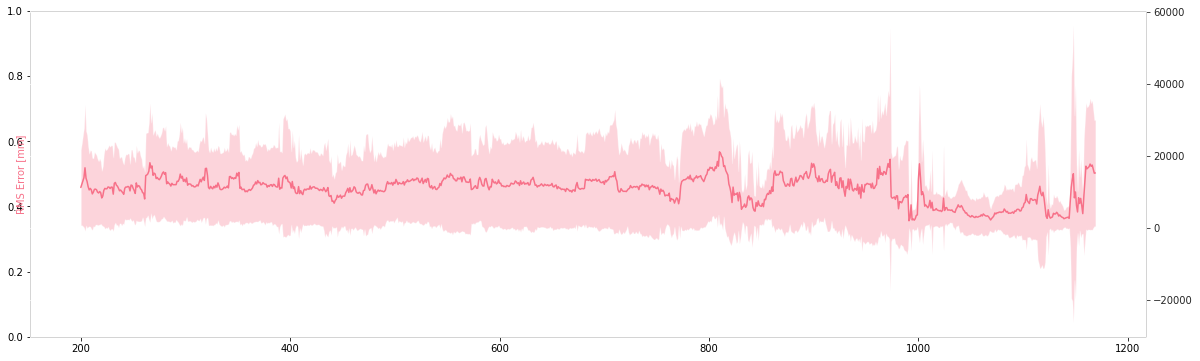

In [13]:
evaluation.plot_error(['ErrorGTs'])

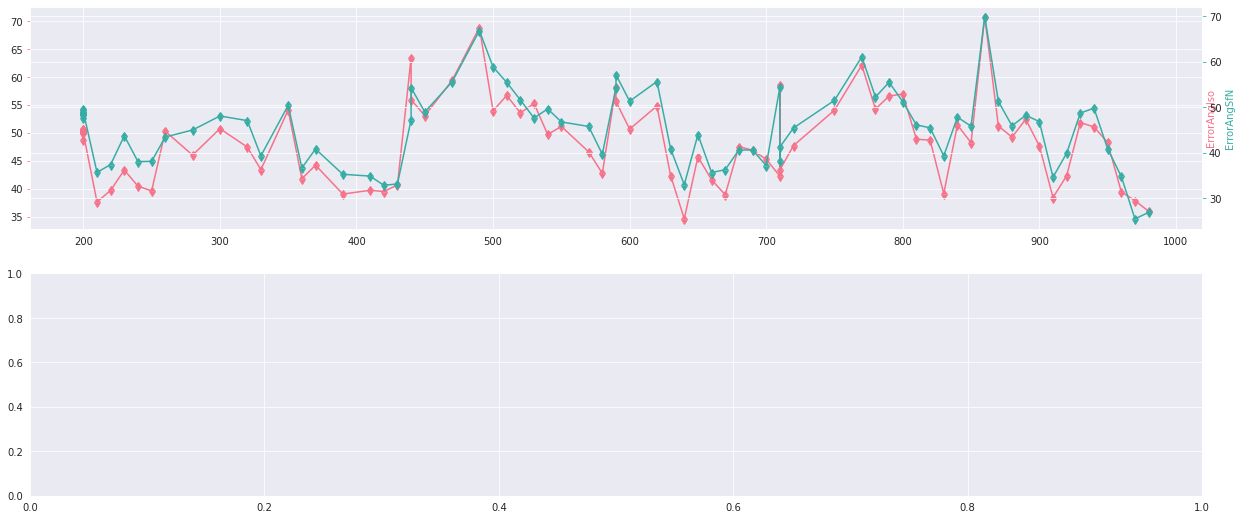

In [14]:
evaluation.plot_error2(['ErrorAngIso','ErrorAngSfN'])

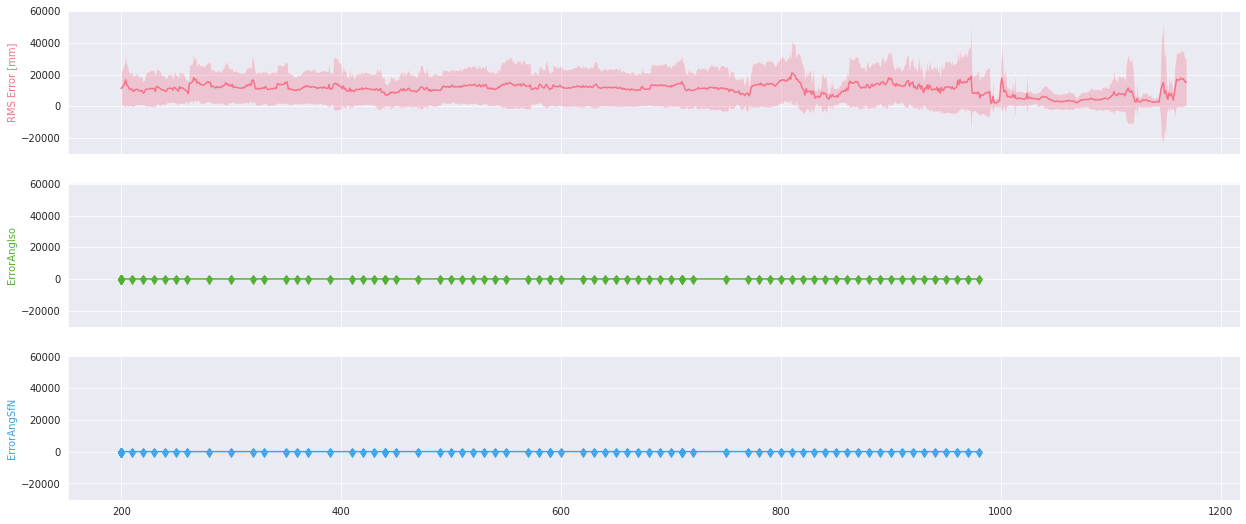

In [15]:
evaluation.plot_error_separated(error_str)

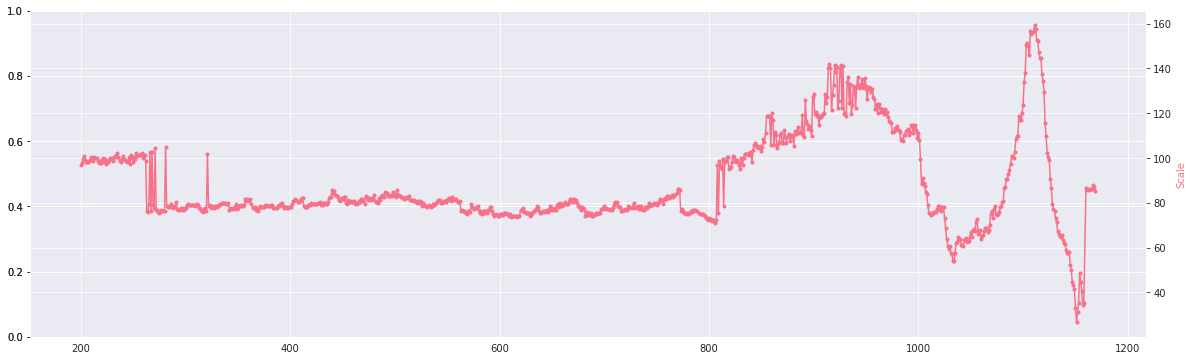

In [16]:
evaluation.plot_error(['Scale'])

In [33]:
evaluation.total_mean_error['ErrorGTs']

11.86347938243608